In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                       | 0/50000 [00:00<?, ?it/s]

  9%|█████                                                    | 4388/50000 [00:00<00:01, 43877.32it/s]

 18%|██████████                                               | 8776/50000 [00:00<00:00, 43315.79it/s]

 26%|██████████████▊                                         | 13220/50000 [00:00<00:00, 43820.80it/s]

 35%|███████████████████▊                                    | 17695/50000 [00:00<00:00, 44184.50it/s]

 44%|████████████████████████▊                               | 22114/50000 [00:00<00:00, 44184.67it/s]

 53%|█████████████████████████████▋                          | 26533/50000 [00:00<00:00, 43581.68it/s]

 62%|██████████████████████████████████▋                     | 30991/50000 [00:00<00:00, 43901.52it/s]

 71%|███████████████████████████████████████▋                | 35472/50000 [00:00<00:00, 44185.79it/s]

 80%|████████████████████████████████████████████▋           | 39892/50000 [00:00<00:00, 43136.93it/s]

 88%|█████████████████████████████████████████████████▌      | 44212/50000 [00:01<00:00, 42462.43it/s]

 97%|██████████████████████████████████████████████████████▍ | 48575/50000 [00:01<00:00, 42810.26it/s]

100%|████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43406.38it/s]

Files already downloaded and verified


  0%|                                                                       | 0/10000 [00:00<?, ?it/s]

 44%|████████████████████████▉                                | 4367/10000 [00:00<00:00, 43660.36it/s]

 88%|██████████████████████████████████████████████████▏      | 8811/10000 [00:00<00:00, 44116.23it/s]

100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 44042.27it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 5izbkda2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-5izbkda2:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                         | 0/313 [00:00<?, ?it/s]

  0%|▏                                                                | 1/313 [00:00<02:33,  2.04it/s]

  7%|████▋                                                           | 23/313 [00:00<00:05, 51.17it/s]

 14%|█████████▏                                                      | 45/313 [00:00<00:02, 92.08it/s]

 22%|█████████████▉                                                 | 69/313 [00:00<00:01, 129.91it/s]

 30%|██████████████████▋                                            | 93/313 [00:00<00:01, 159.36it/s]

 37%|███████████████████████▏                                      | 117/313 [00:00<00:01, 181.34it/s]

 45%|███████████████████████████▉                                  | 141/313 [00:01<00:00, 196.68it/s]

 53%|████████████████████████████████▋                             | 165/313 [00:01<00:00, 208.13it/s]

 60%|█████████████████████████████████████▍                        | 189/313 [00:01<00:00, 216.15it/s]

 68%|██████████████████████████████████████████▏                   | 213/313 [00:01<00:00, 222.76it/s]

 76%|██████████████████████████████████████████████▉               | 237/313 [00:01<00:00, 227.68it/s]

 83%|███████████████████████████████████████████████████▋          | 261/313 [00:01<00:00, 230.91it/s]

 91%|████████████████████████████████████████████████████████▍     | 285/313 [00:01<00:00, 233.04it/s]

 99%|█████████████████████████████████████████████████████████████▏| 309/313 [00:01<00:00, 234.99it/s]

100%|██████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 167.42it/s]

train - OK


  0%|                                                                          | 0/79 [00:00<?, ?it/s]

 14%|████████▉                                                       | 11/79 [00:00<00:00, 106.14it/s]

 44%|████████████████████████████▎                                   | 35/79 [00:00<00:00, 180.78it/s]

 75%|███████████████████████████████████████████████▊                | 59/79 [00:00<00:00, 206.11it/s]

100%|████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 176.74it/s]

val - OK


  0%|                                                                          | 0/79 [00:00<?, ?it/s]

  9%|█████▊                                                            | 7/79 [00:00<00:01, 69.61it/s]

 39%|█████████████████████████                                       | 31/79 [00:00<00:00, 166.61it/s]

 70%|████████████████████████████████████████████▌                   | 55/79 [00:00<00:00, 198.02it/s]

100%|████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 184.20it/s]

test InD - OK


  0%|                                                                         | 0/469 [00:00<?, ?it/s]

  2%|█▏                                                               | 9/469 [00:00<00:05, 88.98it/s]

  7%|████▎                                                          | 32/469 [00:00<00:02, 170.22it/s]

 12%|███████▌                                                       | 56/469 [00:00<00:02, 200.37it/s]

 17%|██████████▋                                                    | 80/469 [00:00<00:01, 214.87it/s]

 22%|█████████████▋                                                | 104/469 [00:00<00:01, 222.73it/s]

 27%|████████████████▉                                             | 128/469 [00:00<00:01, 227.42it/s]

 32%|████████████████████                                          | 152/469 [00:00<00:01, 230.57it/s]

 38%|███████████████████████▎                                      | 176/469 [00:00<00:01, 232.24it/s]

 43%|██████████████████████████▍                                   | 200/469 [00:00<00:01, 233.75it/s]

 48%|█████████████████████████████▌                                | 224/469 [00:01<00:01, 234.73it/s]

 53%|████████████████████████████████▊                             | 248/469 [00:01<00:00, 235.55it/s]

 58%|███████████████████████████████████▉                          | 272/469 [00:01<00:00, 236.04it/s]

 63%|███████████████████████████████████████▏                      | 296/469 [00:01<00:00, 236.20it/s]

 68%|██████████████████████████████████████████▎                   | 320/469 [00:01<00:00, 236.27it/s]

 73%|█████████████████████████████████████████████▍                | 344/469 [00:01<00:00, 236.51it/s]

 78%|████████████████████████████████████████████████▋             | 368/469 [00:01<00:00, 236.40it/s]

 84%|███████████████████████████████████████████████████▊          | 392/469 [00:01<00:00, 236.45it/s]

 89%|██████████████████████████████████████████████████████▉       | 416/469 [00:01<00:00, 236.42it/s]

 94%|██████████████████████████████████████████████████████████▏   | 440/469 [00:01<00:00, 235.99it/s]

 99%|█████████████████████████████████████████████████████████████▎| 464/469 [00:02<00:00, 236.44it/s]

100%|██████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 222.24it/s]

test OoD - OK


  0%|                                                                         | 0/100 [00:00<?, ?it/s]

 25%|███████████████▊                                               | 25/100 [00:00<00:00, 245.61it/s]

 50%|███████████████████████████████▌                               | 50/100 [00:00<00:00, 245.97it/s]

 75%|███████████████████████████████████████████████▎               | 75/100 [00:00<00:00, 246.10it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.96it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 245.65it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 3, 32, 32) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


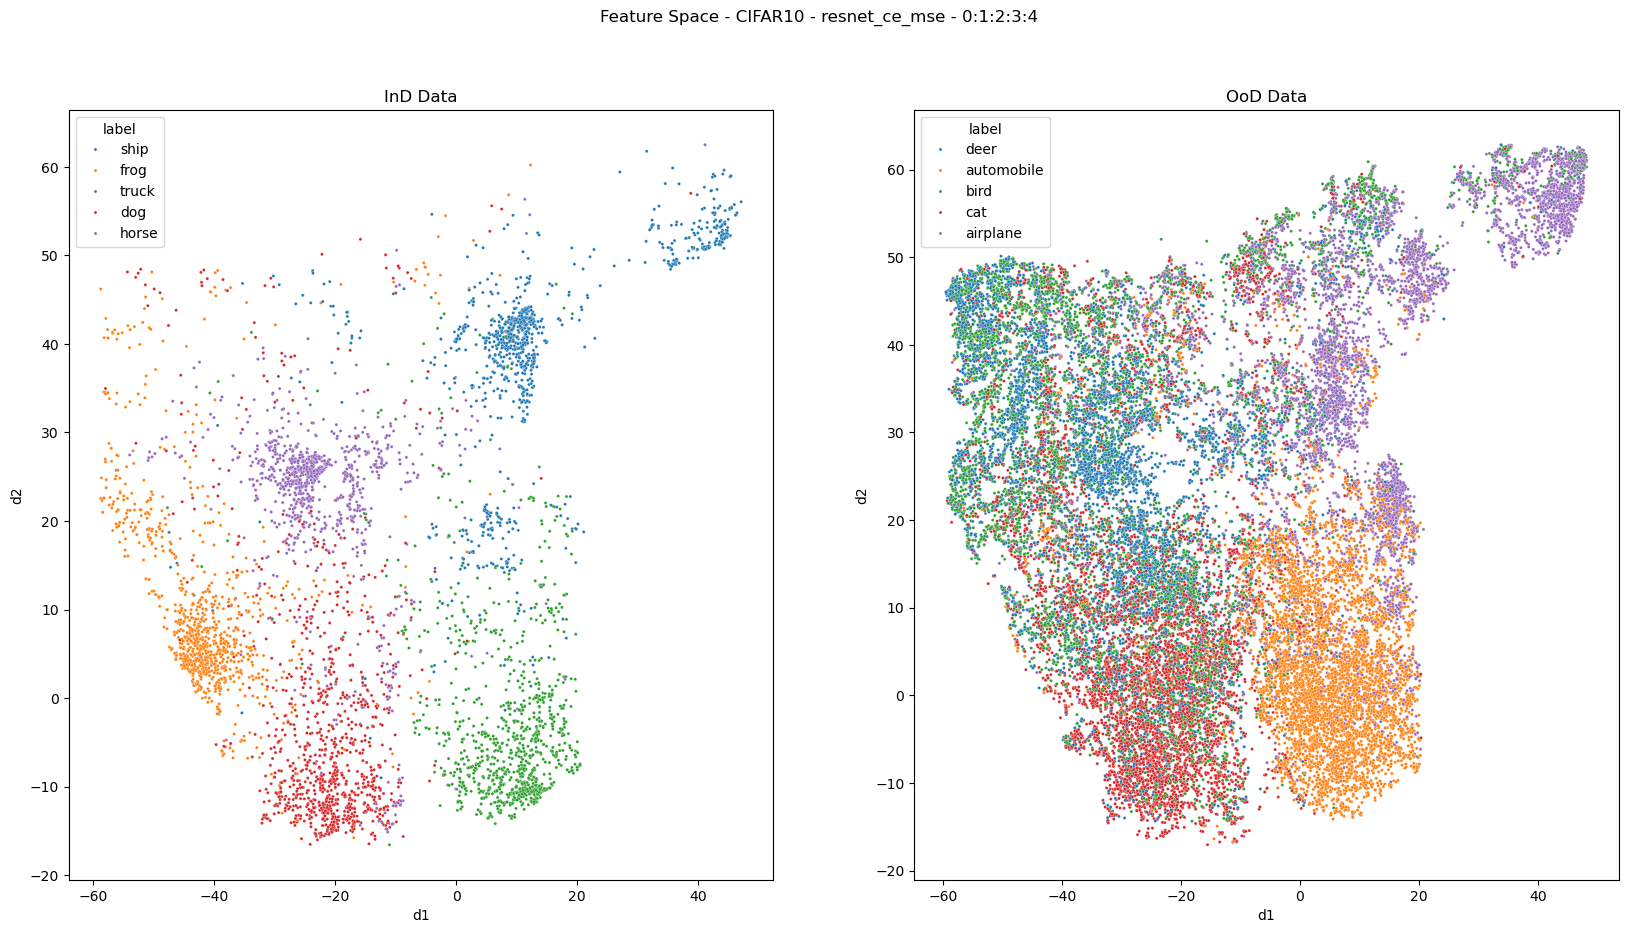

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

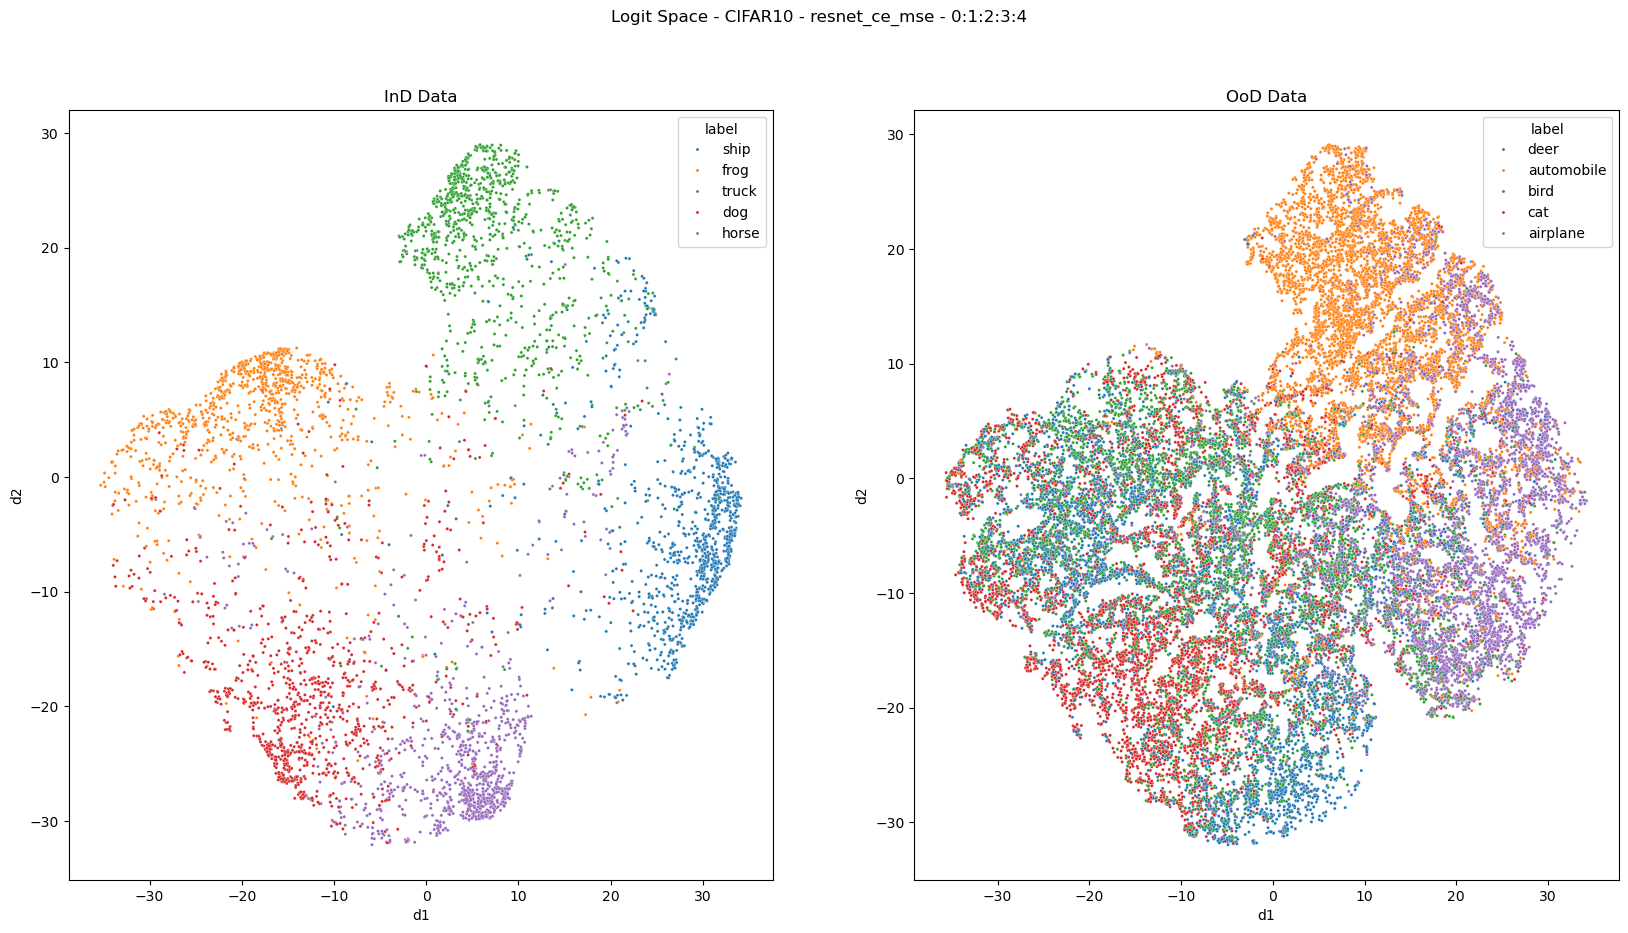

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████▊                                                  | 1/4 [00:01<00:04,  1.39s/it]

 50%|█████████████████████████████████▌                                 | 2/4 [00:02<00:02,  1.49s/it]

 75%|██████████████████████████████████████████████████▎                | 3/4 [00:04<00:01,  1.48s/it]

100%|███████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]

100%|███████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.51s/it]

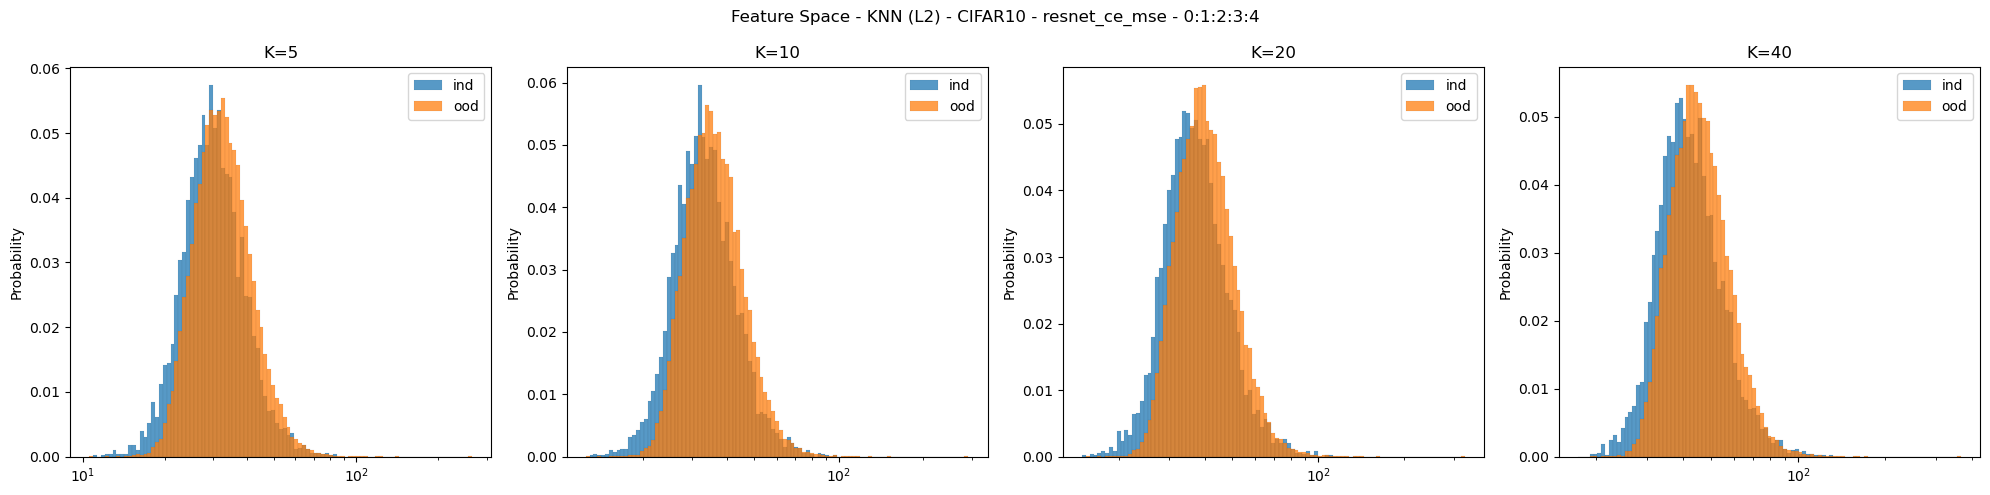

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:01<00:03,  1.30s/it]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:02<00:02,  1.32s/it]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:04<00:01,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/it]

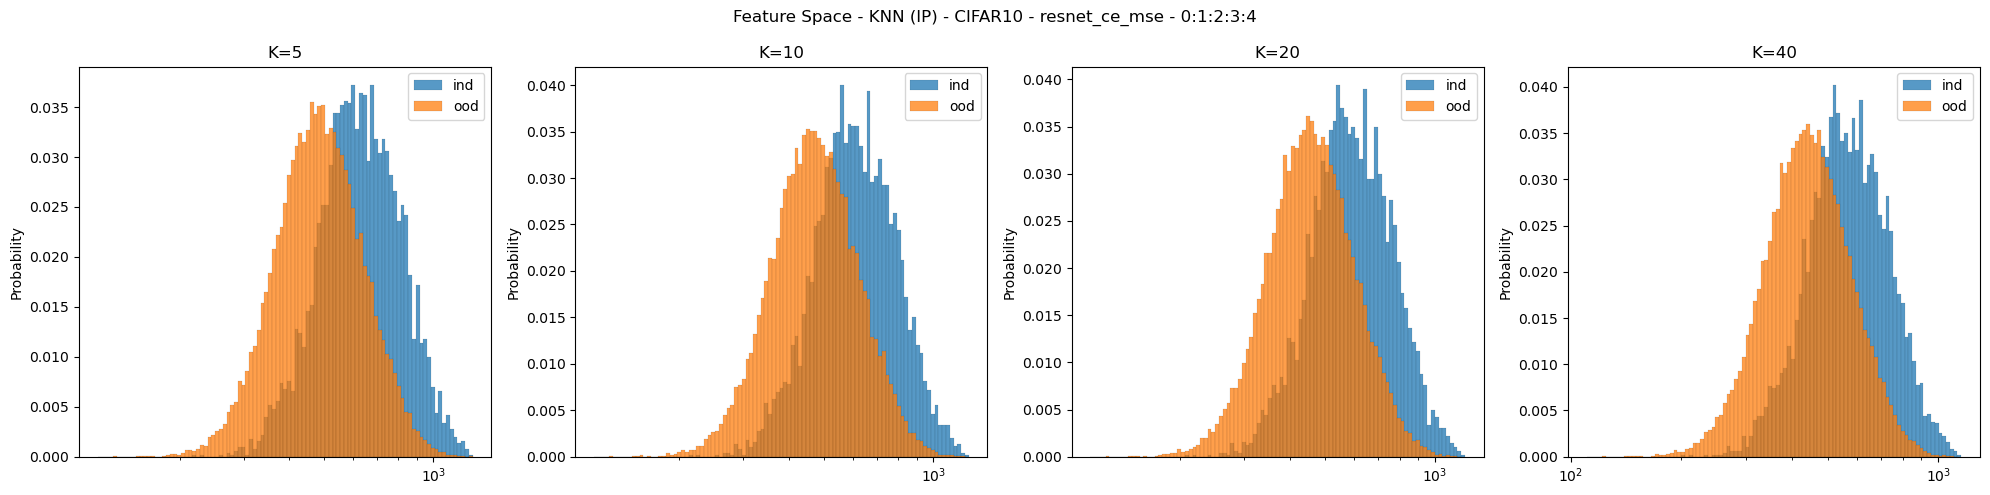

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:00,  3.17it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  3.02it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:01<00:00,  2.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]

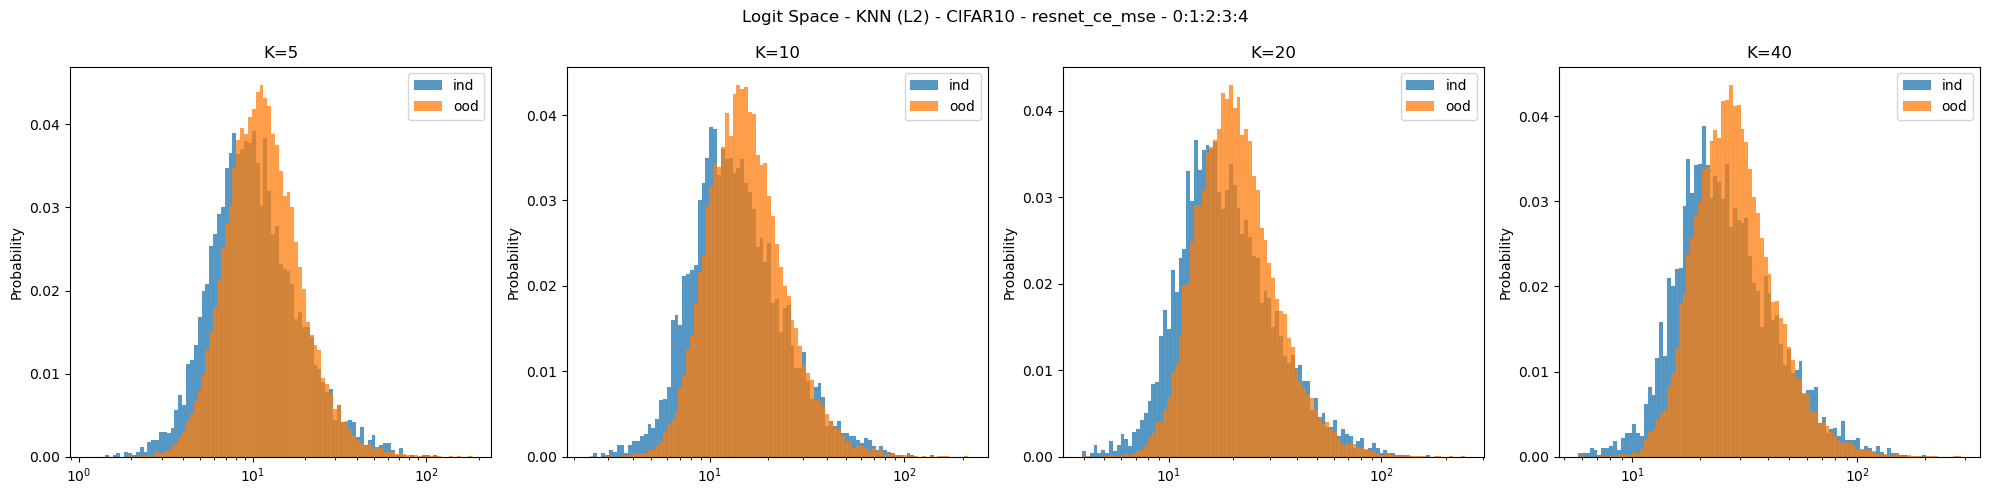

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████                                                                        | 1/4 [00:00<00:00,  3.55it/s]

 50%|████████████████████████████████████████████████                                                | 2/4 [00:00<00:00,  3.30it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [00:01<00:00,  2.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]

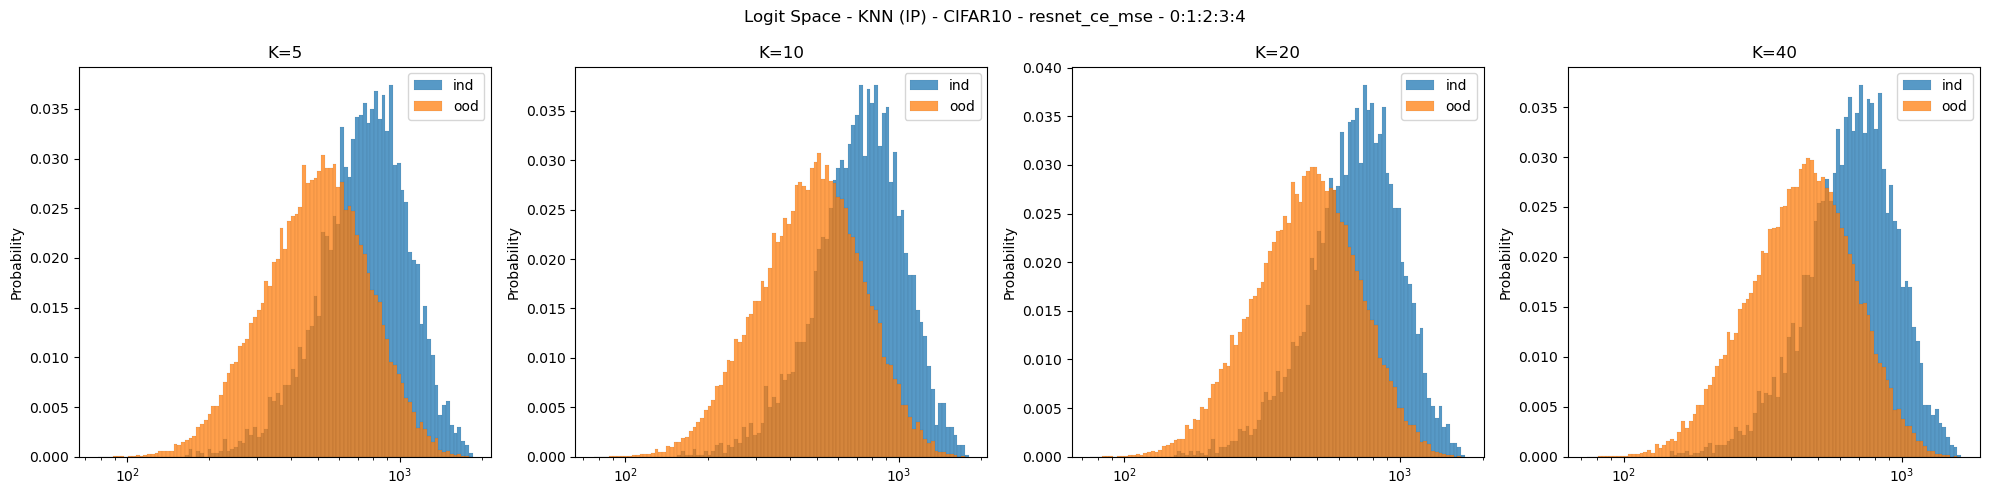

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

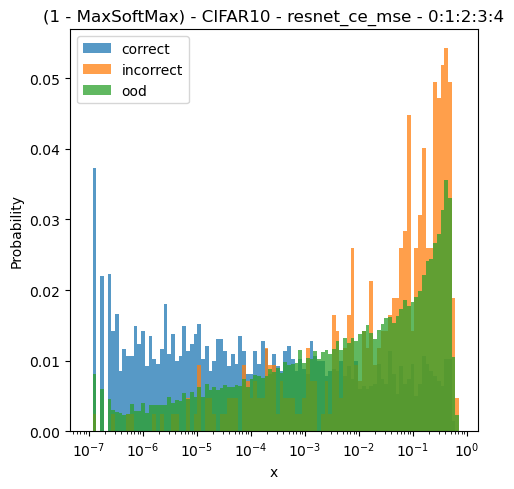

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

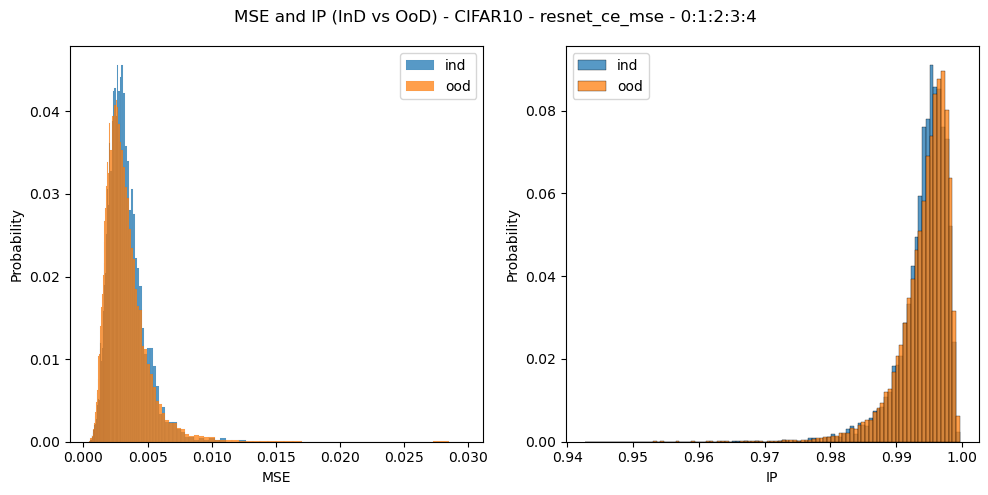

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()